# Tutorial

In [1]:
## enable auto reload
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time
import pickle

## 1. Preprocessed 데이터 로드

In [3]:
from src.utils.data_utils import CWRUDataset
train_dataset = CWRUDataset('./data','train',p=1)
test_dataset = CWRUDataset('./data','test',p=1)

train dataset size:14950, labeled:14950, unlabeled:0
masks : [0:1495, 1:1495, 2:1495, 3:1495, 4:1495, 5:1495, 6:1495, 7:1495, 8:1495, 9:1495]
test dataset size:3760, labeled:3760, unlabeled:0
masks : [0:376, 1:376, 2:376, 3:376, 4:376, 5:376, 6:376, 7:376, 8:376, 9:376]


In [4]:
from torch.utils.data import DataLoader
temp_loader = DataLoader(train_dataset, shuffle=True, batch_size=1)

## 2. 데이터 이해하기

***<A0_DataAnalysis.ipynb>에서 직접 다양하게 실행해볼 수 있습니다.***

Dataloader는 총 3가지 값을 줌
- X (batch_size, 1, frame_length) : input 데이터 배치
- y : (batch_size,) : 배치의 각 데이터의 ground-truth label
- M : (batch_size,) : 배치의 각 데이터가 labeled인지 여부 (labeled일 때 True, unlabeled일 때 False)

(* Unlabeled 데이터의 경우도 y에서 실제 label을 주지만, 프로젝트를 할 때는 함수 안에서 Unlabeled 데이터의 y값을 -1로 가림)

Data shape :  torch.Size([1, 1, 2048])
Ground-truth label :  5
Mask(labeled/unlabeled) :  True


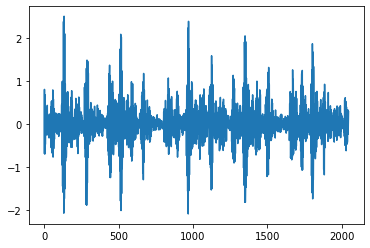

In [5]:
for X,y,M in temp_loader:
    print('Data shape : ',X.shape)
    print('Ground-truth label : ', y.item())
    print('Mask(labeled/unlabeled) : ', M.item())
    plt.plot(X.reshape(-1))
    break
plt.show()

Data shape :  torch.Size([1, 1, 2048])
Ground-truth label :  0
Mask(labeled/unlabeled) :  True


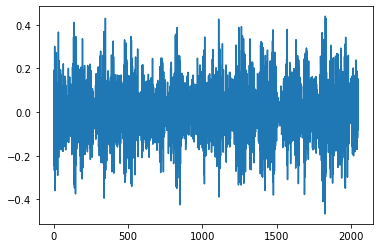

In [6]:
L=0
for X,y,M in temp_loader:
    if y != L:
        continue

    print('Data shape : ',X.shape)
    print('Ground-truth label : ', y.item())
    print('Mask(labeled/unlabeled) : ', M.item())
    plt.plot(X.reshape(-1))
    break
plt.show()

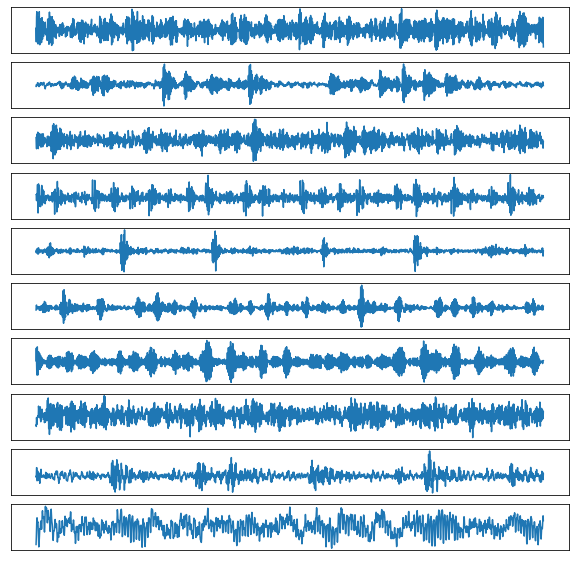

In [7]:
Xs = [False]*10
fig=plt.figure(figsize=(10,10))
for X,y,M in temp_loader:
    if not Xs[y]:
        Xs[y]=True
        ax = plt.subplot(10,1,y.item()+1)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.plot(X.reshape(-1))
    if sum(Xs) >= 10:
        break
plt.show()

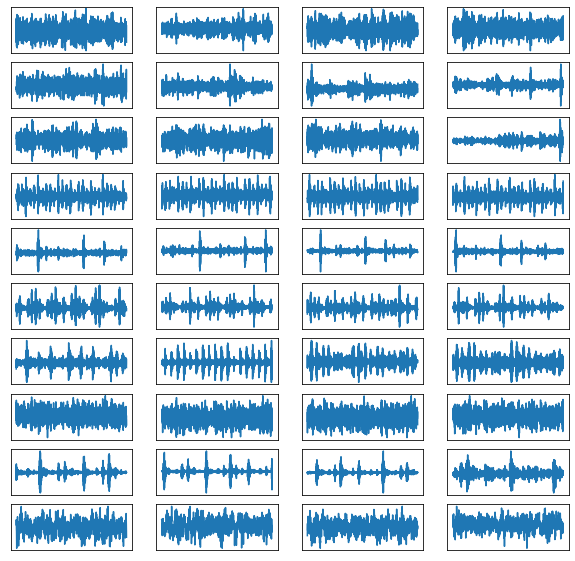

In [8]:
N=4

Xs = [0]*10
fig=plt.figure(figsize=(10,10))
for X,y,M in temp_loader:
    if Xs[y] < N:
        Xs[y] += 1
        ax = plt.subplot(10,N,N*y.item()+Xs[y])
        ax.set_xticks([])
        ax.set_yticks([])
        ax.plot(X.reshape(-1))
    if sum(Xs) >= N*10:
        break
plt.show()

## 3. Supervised Classification

- Labeled 데이터만을 활용해서 supervised classification

In [9]:
## fix seeds for reproducibility
SEED=0
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic=True

### 3.1 Model Definition


In [23]:
'''
    Define BaseModel, which is fully-supervised model in default
'''
class BaseModel(nn.Module):
    def __init__(self,model_name='model',p=None):
        '''
            [Input]
                - model_name : model name
        '''
        super(BaseModel, self).__init__()
        self.name = model_name
        if p is not None:
            self.name += '_p%04d'%(10000*p)
        print('Model Name : %s'%self.name)
        
        self.e=0        ## self.e : save current epoch
        
        ## Save training logs
        self.total_train_loss=[]
        self.total_test_loss=[]
        self.total_train_acc=[]
        self.total_test_acc=[]
        
    def train_model(self, train_dataloader, test_dataloader, epoch, optimizer,**kwargs):
        '''
            [Input]
                - train_dataloader : training dataloader to sample batch from
                - test_dataloader : test dataloader to sample batch from
                - epoch : # of epochs to run
                - optimizer : optimizer
        '''
        best_eval=float('inf')
        
        while True:
            if self.e >= epoch:
                break
            ts = time.time()
            
            ## Training epoch step
            self.train()
            train_loss, train_acc = self.epoch_step(train_dataloader, optimizer=optimizer,**kwargs)
            
            ## Test epoch step
            self.eval()
            with torch.no_grad():
                test_loss, test_acc = self.epoch_step(test_dataloader,**kwargs)
            
            print('(%.2fs) [Epoch %d]'%(time.time()-ts,self.e))
            print('\tTrain Loss : %.5f,\tTrain Acc : %.5f'%(train_loss, train_acc))
            print('\tEval Loss : %.5f,\tEval Acc : %.5f'%(test_loss, test_acc))
            
            self.total_train_loss.append(train_loss)
            self.total_test_loss.append(test_loss)
            self.total_train_acc.append(train_acc)
            self.total_test_acc.append(test_acc)
            
            if self.e%10 == 9:
                torch.save(self.state_dict(), './saved_models/%s_e%d.pth'%(self.name, self.e+1))
                pickle.dump((self.total_train_loss, self.total_test_loss, self.total_train_acc, self.total_test_acc), open('./train_logs/%s.bin'%(self.name),'wb'))
            self.e += 1
    def epoch_step(self, dataloader, optimizer=None,return_result=False,**kwargs):
        '''
            [Input]
                - dataloader : training dataloader to sample batch from
                - optimizer : optimizer
                - return_result : whether to return prediction result or not (for evaluation only)
            [Output]
                - avg_loss : average loss of current epoch
                - accuracy : prediction accuracy of current epoch
        '''
        avg_loss = 0.0
        n = 0
        total_correct = 0
        total_z = []
        total_pred = []
        
        ## For all data
        for batch, label, mask in dataloader:
            ## Upload to GPU
            batch=batch.cuda().to(dtype=torch.float)
            label=label.cuda().to(dtype=torch.long)
            mask = mask.cuda().to(dtype=torch.bool)
            
            ## Screen labels of unlabeled data
            masked_label = label.clone()
            masked_label[~mask] = -1
            
            ## Batch step
            loss, p, z = self.batch_step(batch, masked_label, mask, optimizer=optimizer,**kwargs)
            
            ## Get predicted labels from predicted probabilities
            pred = torch.argmax(p, dim=1)
            
            ## Update moving average of loss
            avg_loss = (n*avg_loss + loss.item()*batch.size(0)) / (n+batch.shape[0])
            n = n+batch.shape[0]
            
            correct = (label[label==pred]).shape[0]
            total_correct += correct
            total_z.append(z.detach().cpu())
            total_pred.append(pred.detach().cpu())
            
        if return_result:
            return avg_loss, total_correct / n, torch.cat(total_z), torch.cat(total_pred)
        return avg_loss, total_correct / n
    
    def batch_step(self, batch, label, mask, optimizer=None):
        '''
            [Input]
                - batch : batch of input data
                - label : ground-truth label
                - mask : mask_ij is True if x_ij is labeled, else False
                - optimizer : optimizer
            [Output]
                - loss : loss
                - p : batch of predicted probabilites for each categories
                - z : latent vector
        '''
        ## Forward pass
        p, loss, z = self.forward(batch, label, mask)
        
        ## Update model weight if training and loss is computed
        if self.training and (loss is not None):
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
        if loss is None:
            loss = torch.tensor(0.0)
            
        return loss, p, z
    
    
    def predict(self, dataloader, **kwargs):
        '''
            [Input]
                - dataloader : dataloader to sample batches from
            [Output]
                - z : latent vectors
                - pred : predictions
        '''
        self.eval()
        with torch.no_grad():
            loss,acc,z,pred = self.epoch_step(dataloader,return_result=True,**kwargs)
        return acc, z, pred

기본 모델 : WDCNN
- A New Deep Learning Model for Fault Diagnosis with Good Anti-Noise and Domain Adaptation Ability on Raw Vibration Signals (Zhang et al., 2017)
- TBD : 설명

In [24]:
class WDCNN(BaseModel):
    def __init__(self, in_dim=1, h_dim=64,out_dim=10,model_name='wdcnn',*args,**kwargs):
        super(WDCNN, self).__init__(model_name=model_name, *args,**kwargs)
        self.conv1 = self._conv_block(in_dim, 16, 64, 16, 24)
        self.conv2 = self._conv_block(16, 32, 3, 1, 1)
        self.conv3 = self._conv_block(32,64,3,1,1)
        self.conv4 = self._conv_block(64,h_dim,3,1,1)
        self.conv5 = self._conv_block(h_dim,h_dim,3,1,0)
        self.fc = nn.Linear(h_dim, out_dim)
        
    def _conv_block(self, in_dim, out_dim, k,s,p):
        return nn.Sequential(
            nn.Conv1d(in_dim, out_dim, kernel_size=k,stride=s,padding=p, bias=False),
            nn.BatchNorm1d(out_dim),
            nn.MaxPool1d(kernel_size=2, stride=2),
            nn.ReLU()
        )
    def forward(self, x, y, mask):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        
        z = x.mean(-1)
        
        x = self.fc(z)
        if mask.any():
            loss = nn.CrossEntropyLoss()(x[mask],y[mask])
        else:
            loss=None
        return x, loss, z

### 3.2 Train Configurations

In [12]:
## Train configurations
LR = 1e-3        ## learning rate
BATCH = 32      ## batch size
EPOCH = 10      ## # of epochs to run
SAVE_PATH = './saved_models'  ## path to save model weights
LOG_PATH = './train_logs'  ## path to save train logs
TEST_PATH = './test_results'  ## path to save test results
SAV_INTV = 10                 ## save model on every SAV_INTV epochs

## Make necessary directories
if not os.path.exists(SAVE_PATH):
    os.mkdir(SAVE_PATH)
if not os.path.exists(LOG_PATH):
    os.mkdir(LOG_PATH)
if not os.path.exists(TEST_PATH):
    os.mkdir(TEST_PATH)
    
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(DEVICE)

cuda


### 3.3 Supervised classification given labels for all data

In [13]:
train_dataloader = DataLoader(train_dataset, batch_size=BATCH, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH)

In [14]:
'''
    Train WDCNN
'''
## generate WDCNN
model = WDCNN()

## and send it to GPU
model.cuda()

## ADAM optimizer to train model weights
optimizer = optim.Adam(model.parameters(), lr=LR)

## train model
model.train_model(train_dataloader, test_dataloader, EPOCH, optimizer)

Model Name : wdcnn
(6.02s) [Epoch 0]
	Train Loss : 0.31156,	Train Acc : 0.93679
	Eval Loss : 0.02409,	Eval Acc : 0.99574
(4.10s) [Epoch 1]
	Train Loss : 0.02688,	Train Acc : 0.99465
	Eval Loss : 0.04953,	Eval Acc : 0.97952
(4.08s) [Epoch 2]
	Train Loss : 0.00923,	Train Acc : 0.99873
	Eval Loss : 0.01197,	Eval Acc : 0.99707
(4.05s) [Epoch 3]
	Train Loss : 0.00698,	Train Acc : 0.99866
	Eval Loss : 0.01587,	Eval Acc : 0.99415
(3.99s) [Epoch 4]
	Train Loss : 0.01410,	Train Acc : 0.99645
	Eval Loss : 0.00955,	Eval Acc : 0.99787
(4.02s) [Epoch 5]
	Train Loss : 0.00312,	Train Acc : 0.99920
	Eval Loss : 0.00588,	Eval Acc : 0.99814
(4.01s) [Epoch 6]
	Train Loss : 0.00521,	Train Acc : 0.99893
	Eval Loss : 0.00928,	Eval Acc : 0.99628
(4.22s) [Epoch 7]
	Train Loss : 0.00390,	Train Acc : 0.99920
	Eval Loss : 0.02778,	Eval Acc : 0.99335
(4.14s) [Epoch 8]
	Train Loss : 0.00608,	Train Acc : 0.99819
	Eval Loss : 0.00333,	Eval Acc : 0.99867
(4.08s) [Epoch 9]
	Train Loss : 0.00520,	Train Acc : 0.99866
	E

### 3.4 Supervised classification given labels for 0.5% of data

In [15]:
train_dataset = CWRUDataset('./data','train',p=0.005)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH, shuffle=True)

train dataset size:14950, labeled:74, unlabeled:14876
masks : [0:8, 1:4, 2:8, 3:8, 4:6, 5:7, 6:8, 7:9, 8:9, 9:7]


In [16]:
'''
    Train WDCNN
'''
## generate WDCNN
model = WDCNN(p=0.005)

## and send it to GPU
model.cuda()

## ADAM optimizer to train model weights
optimizer = optim.Adam(model.parameters(), lr=LR)

## train model
model.train_model(train_dataloader, test_dataloader, EPOCH, optimizer)

Model Name : wdcnn_p0050
(2.14s) [Epoch 0]
	Train Loss : 0.30269,	Train Acc : 0.25077
	Eval Loss : 1.70995,	Eval Acc : 0.39707
(2.13s) [Epoch 1]
	Train Loss : 0.21694,	Train Acc : 0.46167
	Eval Loss : 1.40937,	Eval Acc : 0.49521
(2.15s) [Epoch 2]
	Train Loss : 0.16925,	Train Acc : 0.54656
	Eval Loss : 1.10920,	Eval Acc : 0.73617
(2.20s) [Epoch 3]
	Train Loss : 0.11782,	Train Acc : 0.66836
	Eval Loss : 1.00412,	Eval Acc : 0.66463
(2.28s) [Epoch 4]
	Train Loss : 0.07883,	Train Acc : 0.73786
	Eval Loss : 0.83075,	Eval Acc : 0.77979
(2.16s) [Epoch 5]
	Train Loss : 0.04043,	Train Acc : 0.78448
	Eval Loss : 0.75133,	Eval Acc : 0.80638
(2.09s) [Epoch 6]
	Train Loss : 0.02083,	Train Acc : 0.79431
	Eval Loss : 0.65624,	Eval Acc : 0.83910
(2.12s) [Epoch 7]
	Train Loss : 0.00829,	Train Acc : 0.82080
	Eval Loss : 0.68760,	Eval Acc : 0.82394
(2.09s) [Epoch 8]
	Train Loss : 0.00494,	Train Acc : 0.81237
	Eval Loss : 0.66678,	Eval Acc : 0.81968
(2.11s) [Epoch 9]
	Train Loss : 0.00344,	Train Acc : 0.80

### 3.5 Check training logs

In [17]:
MODEL_NAMES = ['wdcnn', 'wdcnn_p0050']

In [20]:
def plot_logs(models,log_path='./train_logs'):
    fig=plt.figure(figsize=(10,10))
    AX_NAME = ['Train Loss','Test Loss','Train Acc', 'Test Acc']
    for m in models:
        if not os.path.isfile(log_path+'/%s.bin'%m):
            print('No %s'%m)
            continue
        results = pickle.load(open(log_path+'/%s.bin'%m,'rb'))
        for i,r in enumerate(results):
            ax = plt.subplot(2,2,i+1)
            ax.set_title(AX_NAME[i])
            ax.plot(r, label=m)
            if i<1:
                ax.legend()
    plt.show()

d:\users\jh\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # Remove the CWD from sys.path while we load stuff.


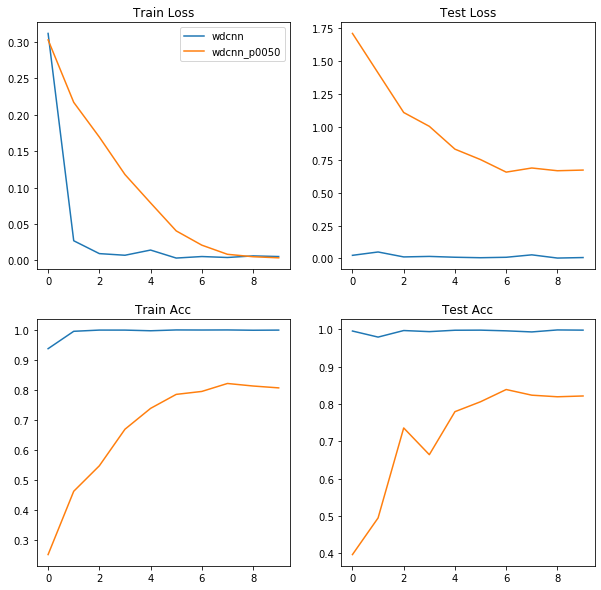

In [21]:
plot_logs(MODEL_NAMES,LOG_PATH)

In [37]:
def test_model(model, split='test', SNR=None, overwrite=False, test_path='./test_results'):
    if SNR is None:
        SNR = [None,8,4,2,0]
    model.cuda()
    for snr in SNR:
        if not overwrite:
            if os.path.isfile(test_path+'/pred_%s[%s]_%s.npy'%(model.name, snr, split)):
                if os.path.isfile(test_path+'/z_%s[%s]_%s.npy'%(model.name,snr,split)):
                    if os.path.isfile(test_path+'/result_%s[%s]_%s.bin'%(model.name,snr,split)):
                        print('pass %s (%s, SNR=%s)'%(model.name,split,snr))
                        continue
        dataset = CWRUDataset('./data',split,p=1,snr=snr)
        dataloader = DataLoader(dataset,batch_size=32)
        acc,z,pred = model.predict(dataloader)
        pred = pred.numpy()
        
        pred = np.stack([dataset.labels,pred],axis=0)
        np.save(test_path+'/pred_%s[%s]_%s.npy'%(model.name, snr, split), pred)
        z=z.numpy()
        
        np.save(test_path+'/z_%s[%s]_%s.npy'%(model.name,snr,split),z)
        pickle.dump(acc, open(test_path+'/result_%s[%s]_%s.bin'%(model.name,snr,split),'wb'))
        print('(%s) %s (SNR=%s) :\t%s'%(split,model.name,snr,acc))

In [38]:
MODEL_NAMES = ['wdcnn_p0050_e10']
MODELS = [WDCNN]
for i in range(len(MODEL_NAMES)):
    model = MODELS[i](model_name = MODEL_NAMES[i])
    model.load_state_dict(torch.load(SAVE_PATH+'/'+MODEL_NAMES[i]+'.pth'))
    
    test_model(model, overwrite=True)
    test_model(model, split='train', overwrite=True)

Model Name : wdcnn_p0050_e10
test dataset size:3760, labeled:3760, unlabeled:0
masks : [0:376, 1:376, 2:376, 3:376, 4:376, 5:376, 6:376, 7:376, 8:376, 9:376]
(test) wdcnn_p0050_e10 (SNR=None) :	0.8218085106382979
test dataset size:3760, labeled:3760, unlabeled:0
masks : [0:376, 1:376, 2:376, 3:376, 4:376, 5:376, 6:376, 7:376, 8:376, 9:376]
(test) wdcnn_p0050_e10 (SNR=8) :	0.7872340425531915
test dataset size:3760, labeled:3760, unlabeled:0
masks : [0:376, 1:376, 2:376, 3:376, 4:376, 5:376, 6:376, 7:376, 8:376, 9:376]
(test) wdcnn_p0050_e10 (SNR=4) :	0.7015957446808511
test dataset size:3760, labeled:3760, unlabeled:0
masks : [0:376, 1:376, 2:376, 3:376, 4:376, 5:376, 6:376, 7:376, 8:376, 9:376]
(test) wdcnn_p0050_e10 (SNR=2) :	0.6335106382978724
test dataset size:3760, labeled:3760, unlabeled:0
masks : [0:376, 1:376, 2:376, 3:376, 4:376, 5:376, 6:376, 7:376, 8:376, 9:376]
(test) wdcnn_p0050_e10 (SNR=0) :	0.5226063829787234
train dataset size:14950, labeled:14950, unlabeled:0
masks : [0

In [39]:
def make_table(model_names, split='test',test_path='./test_results', SNR=None):
    if SNR is None:
        SNR = [None,8,4,2,0]
    for i,m in enumerate(model_names):
        acc_mat = []
        ax = plt.subplot2grid((len(model_names)+2,len(SNR)+1),(i+1,1),colspan=len(SNR),rowspan=1)
        if i==0:
            ax.set_xticks(np.arange(len(SNR)))
            ax.set_xticklabels([x if x is not None else 'None' for x in SNR])
            ax.xaxis.tick_top()
            ax.set_xlabel("SNR")
            ax.xaxis.set_label_position('top')
        else:
            ax.set_xticks([])
        ax.set_yticks([])
        ax.set_ylabel(m)
        
        acc_row = []
        for k, snr in enumerate(SNR):
            if os.path.isfile(test_path+'/result_%s[%s]_%s.bin'%(m,snr,split)):
                acc = pickle.load(open(test_path+'/result_%s[%s]_%s.bin'%(m,snr,split), 'rb'))
            else:
                acc = 0.0
            ax.text(k,0,'%.2f'%(100*acc),ha='center',va='center',color='black')
            acc_row.append(acc)
        acc_mat.append(acc_row)
        acc_mat = [[x**2 for x in y] for y in acc_mat]
        ax.imshow(acc_mat,vmin=0,vmax=1,cmap='RdYlGn',aspect='auto')
    plt.show()

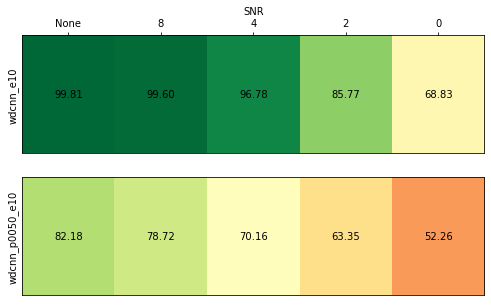

In [40]:
MODEL_NAMES = ['wdcnn_e10', 'wdcnn_p0050_e10']
fig=plt.figure(figsize=(10,10))
make_table(MODEL_NAMES)

In [41]:
def make_confmat(model_name, split='test',test_path='./test_results', snr=None):
    if os.path.isfile(test_path+'/pred_%s[%s]_%s.npy'%(model_name,snr,split)):
        preds = np.load(test_path+'/pred_%s[%s]_%s.npy'%(model_name,snr,split))
        
        y = preds[0]
        preds= preds[1]
        
        matrix = [[len(y[(y==i)&(preds==j)]) for j in range(10)] for i in range(10)]
        fig,ax = plt.subplots()
        im = ax.imshow(matrix, cmap='viridis')
        ax.set_xlabel('Pred')
        ax.set_ylabel('True')
        for i in range(10):
            for j in range(10):
                text = ax.text(j,i,matrix[i][j],ha='center',va='center',color='w')
        fig.tight_layout()
        plt.show()
    else:
        print('no test results')

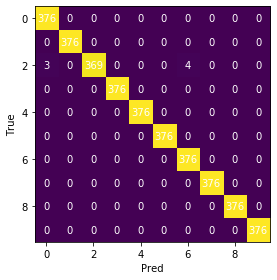

In [42]:
make_confmat(model_name = 'wdcnn_e10',snr=None)

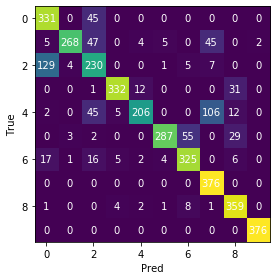

In [43]:
make_confmat(model_name = 'wdcnn_p0050_e10',snr=None)

### 3.6 Latent Vector Analysis
Latent Vector Analysis에서는 Encoder의 output들이 어떻게 분포하는지를 분석합니다. Encoder의 output인 Latent Vector는 고차원이므로, t-SNE 와 같은 저차원을 Visualization 을 통해 분석해볼 수 있습니다. 

Latent vector들이 각각 Label, Prediction, Diameter, RPM에 따라 어떻게 분포하는지 mapping 하고, Model이 형성하고 있는 Latent space 가 데이터셋을 잘 표현하고 있는 representation인지 분석합니다.

In [55]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

In [56]:
def get_tsne(model_name, split='test',test_path='./test_results', snr=None, overwrite=False):
    if (not overwrite) and os.path.isfile(test_path+'/tsne_%s[%s]_%s.npy'%(model_name,snr,split)):
        return np.load(test_path+'/tsne_%s[%s]_%s.npy'%(model_name,snr,split))
    if not os.path.isfile(test_path+'/z_%s[%s]_%s.npy'%(model_name,snr,split)):
        print('no test result')
        return
    z = np.load(test_path+'/z_%s[%s]_%s.npy'%(model_name,snr,split))
    tsne = TSNE()
    z_shrink = tsne.fit_transform(z)
    np.save(test_path+'/tsne_%s[%s]_%s.npy'%(model_name,snr,split), z_shrink)
    return z_shrink

def get_pca(model_name, split='test',test_path='./test_results', snr=None, overwrite=False):
    if (not overwrite) and os.path.isfile(test_path+'/pca_%s[%s]_%s.npy'%(model_name,snr,split)):
        return np.load(test_path+'/pca_%s[%s]_%s.npy'%(model_name,snr,split))
    if not os.path.isfile(test_path+'/z_%s[%s]_%s.npy'%(model_name,snr,split)):
        print('no test result')
        return
    z = np.load(test_path+'/z_%s[%s]_%s.npy'%(model_name,snr,split))
    tsne = PCA()
    z_shrink = tsne.fit_transform(z)
    np.save(test_path+'/pca_%s[%s]_%s.npy'%(model_name,snr,split), z_shrink)
    return z_shrink


In [57]:
MODEL_NAME = 'wdcnn_p0050_e10'
f = get_pca(MODEL_NAME,split='train',overwrite=True)
print(f.shape)

(14950, 64)


In [58]:
def draw_plot(ax, f, arg, difference=False, split='test',legend=True):
    if difference:
        pred, dataset = arg
        scatter = ax.scatter(f[:,0],f[:,1],c=dataset.labels==pred,s=1,alpha=0.5,picker=5,cmap='Set1')
        lines, labels = scatter.legend_elements()
        labels = ['Misclassified','Correct']
        if split == 'train':
            scatter = ax.scatter(f[:,0][dataset.mask],f[:,1][dataset.mask],c='blue',s=5,label='Labeled')
            legend2 = scatter.legend_elements()
        if legend:
            legend = ax.legend(lines, labels)
            ax.add_artist(legend)
    else:
        cmap = plt.cm.get_cmap('viridis')
        scatter = ax.scatter(f[:,0],f[:,1],c=arg,s=1,picker=5)
        lines, labels = scatter.legend_elements()
        labels = [str(i) for i in range(10)]
        if legend:
            legend = ax.legend(lines,labels)
            ax.add_artist(legend)            

In [59]:
def plot_latent(model_name, split='test',test_path='./test_results', snr=None,p=1, overwrite_tsne=False, mode='pca'):
    if mode == 'pca':
        f = get_pca(model_name, split, test_path, snr, overwrite=overwrite_tsne)
    elif mode == 'tsne':
        f = get_tsne(model_name, split, test_path, snr, overwrite=overwrite_tsne)
    else:
        print('undefined mode: %s'%mode)
    fig=plt.figure(figsize=(15,5))
    
    dataset = CWRUDataset('./data',split,p=p,snr=snr)
    pred = np.load(test_path+'/pred_%s[%s]_%s.npy'%(model_name,snr,split))
    pred=pred[1]
    ax0 = plt.subplot(131)
    ax0.set_title('True Label')
    ax1 = plt.subplot(132)
    ax1.set_title('Prediction')
    ax2=plt.subplot(133)
    ax2.set_title('Difference')
    
    ax0.set_xticks([])
    ax1.set_xticks([])
    ax2.set_xticks([])
    ax0.set_yticks([])
    ax1.set_yticks([])
    ax2.set_yticks([])
    draw_plot(ax0,f,dataset.labels,split=split)
    draw_plot(ax1,f,pred,split=split)
    draw_plot(ax2,f,(pred,dataset),difference=True,split=split)
    plt.show()

train dataset size:14950, labeled:74, unlabeled:14876
masks : [0:8, 1:4, 2:8, 3:8, 4:6, 5:7, 6:8, 7:9, 8:9, 9:7]


C:\Users\jh\AppData\Roaming\Python\Python36\site-packages\matplotlib\collections.py:960: UserWarning: Collection without array used. Make sure to specify the values to be colormapped via the `c` argument.
  warnings.warn("Collection without array used. Make sure to "


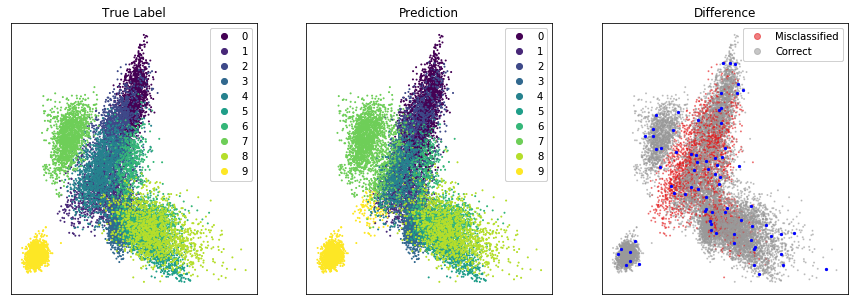

In [60]:
plot_latent(MODEL_NAME,split='train',p=0.005, mode='pca')

In [61]:
def draw_magic(model_name, split='test',test_path='./test_results', snr=None,p=1,legend=True, mode='pca'):
    global picked,m,pick
    picked=None
    m=0
    pick=False
    fig=plt.figure(figsize=(5,5))
    
    ax0 = plt.subplot2grid((4,1),(0,0),rowspan=3)#(3,1,1)
    ax1 = plt.subplot(414)
    ax0.set_xticks([])
    ax0.set_yticks([])
    ax1.set_xticks([])
    ax1.set_yticks([])
    
    titles = ['True Label','Prediction','Difference']
    text = ax0.text(0,100,"%s"%titles[m],va='top',ha='left')
    
    dataset = CWRUDataset('./data',split,p=p,snr=snr)
    pred = np.load(test_path+'/pred_%s[%s]_%s.npy'%(model_name,snr,split))
    pred=pred[1]
    if mode == 'pca':
        f = get_pca(model_name, split, test_path, snr)
    elif mode == 'tsne':
        f = get_tsne(model_name, split, test_path, snr)
    else:
        print('undefined mode: %s'%mode)
    
    def onpress(event):
        global m,pick
        if event.key=='right' and m < len(titles)-1:
            m+=1
        elif event.key == 'left' and m > 0:
            m-=1
        else:
            return
        if pick:
            picked.remove()
            pick=False
        ax0.cla()
        ax0.set_xticks([])
        ax0.set_yticks([])
        text = ax0.text(0,100,"%s"%titles[m],va='top',ha='left')
        if m==0:
            arg=dataset.labels
        elif m==1:
            arg=pred
        else:
            arg=(pred,dataset)
        draw_plot(ax0,f,arg,split=split,difference=(m==2),legend=legend)
        fig.canvas.draw()
        
    def onpick(event):
        global picked,pick
        pt = event.ind[0]
        if pick:
            picked.remove()
            pick=False
        picked = ax0.scatter(f[pt,0],f[pt,1],marker='x',s=10,c='r')
        pick=True
        
        ax1.cla()
        ax1.set_xticks([])
        ax1.set_yticks([])
        raw,_,_ = dataset[pt]
        ax1.plot(raw.reshape(-1))
        fig.canvas.draw()
    
    cid = fig.canvas.mpl_connect('pick_event', onpick)
    cid2 = fig.canvas.mpl_connect('key_press_event', onpress)
    draw_plot(ax0, f,dataset.labels,split=split,difference=False,legend=legend)
    plt.show()

<IPython.core.display.Javascript object>


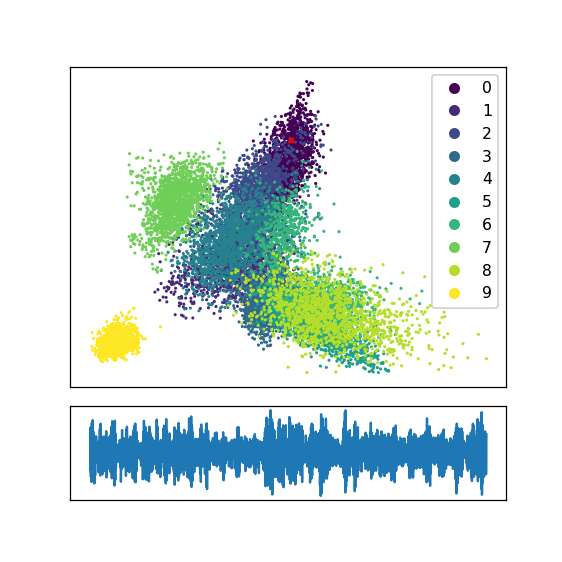

train dataset size:14950, labeled:74, unlabeled:14876
masks : [0:8, 1:4, 2:8, 3:8, 4:6, 5:7, 6:8, 7:9, 8:9, 9:7]


In [62]:
%matplotlib notebook
draw_magic(MODEL_NAME,split='train',p=0.005, legend=True)

# Recap : Consistency Regularization
(by phase shift)

In [69]:
def CrossEntropy(q,p):
    b = F.softmax(p, dim=1) * F.log_softmax(q, dim=1)
    b = -1.0*b.mean()
    return b

class ConsistencyModel(WDCNN):
    def __init__(self, model_name='consistency_model',*args, **kwargs):
        super(ConsistencyModel, self).__init__(model_name=model_name, *args,**kwargs)
    def batch_step(self, batch, label, mask, optimizer=None):
            
        ## regularize consistency with 1-shift data
        batch_original = batch[:,:,:-1]
        batch_perturbed = batch[:,:,1:]
        
        ## Forward pass for original data
        p_original, loss, z = self.forward(batch_original, label, mask)
        
        ## Forward pass for shifted data
        p_perturbed, _, _ = self.forward(batch_perturbed, label, mask)
        
        ## compute distance loss
        dist_loss = CrossEntropy(p_perturbed, p_original)
        
        if loss is None:
            loss = torch.tensor(0.0)
        loss = loss + dist_loss
        
        if self.training and (loss is not None):
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        
        return loss, p_original, z
        

In [70]:
## generate consistency model
model = ConsistencyModel(p=0.005)
model.cuda()
optimizer = optim.Adam(model.parameters(), lr=LR)

train_dataset = CWRUDataset('./data','train',p=0.005)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH, shuffle=True)

model.train_model(train_dataloader, test_dataloader, EPOCH, optimizer)

Model Name : consistency_model_p0050
train dataset size:14950, labeled:74, unlabeled:14876
masks : [0:8, 1:4, 2:8, 3:8, 4:6, 5:7, 6:8, 7:9, 8:9, 9:7]
(5.61s) [Epoch 0]
	Train Loss : 0.52785,	Train Acc : 0.19773
	Eval Loss : 1.83920,	Eval Acc : 0.32021
(5.89s) [Epoch 1]
	Train Loss : 0.35338,	Train Acc : 0.41104
	Eval Loss : 1.35971,	Eval Acc : 0.60186
(5.75s) [Epoch 2]
	Train Loss : 0.24040,	Train Acc : 0.61779
	Eval Loss : 1.00674,	Eval Acc : 0.72234
(5.95s) [Epoch 3]
	Train Loss : 0.19165,	Train Acc : 0.66268
	Eval Loss : 0.91437,	Eval Acc : 0.72048
(5.85s) [Epoch 4]
	Train Loss : 0.13344,	Train Acc : 0.75452
	Eval Loss : 1.03215,	Eval Acc : 0.70824
(5.79s) [Epoch 5]
	Train Loss : 0.09077,	Train Acc : 0.80836
	Eval Loss : 0.44319,	Eval Acc : 0.85027
(5.64s) [Epoch 6]
	Train Loss : 0.04880,	Train Acc : 0.87003
	Eval Loss : 0.34825,	Eval Acc : 0.91356
(5.48s) [Epoch 7]
	Train Loss : 0.11122,	Train Acc : 0.78977
	Eval Loss : 0.37874,	Eval Acc : 0.88457
(5.67s) [Epoch 8]
	Train Loss : 0.

<IPython.core.display.Javascript object>


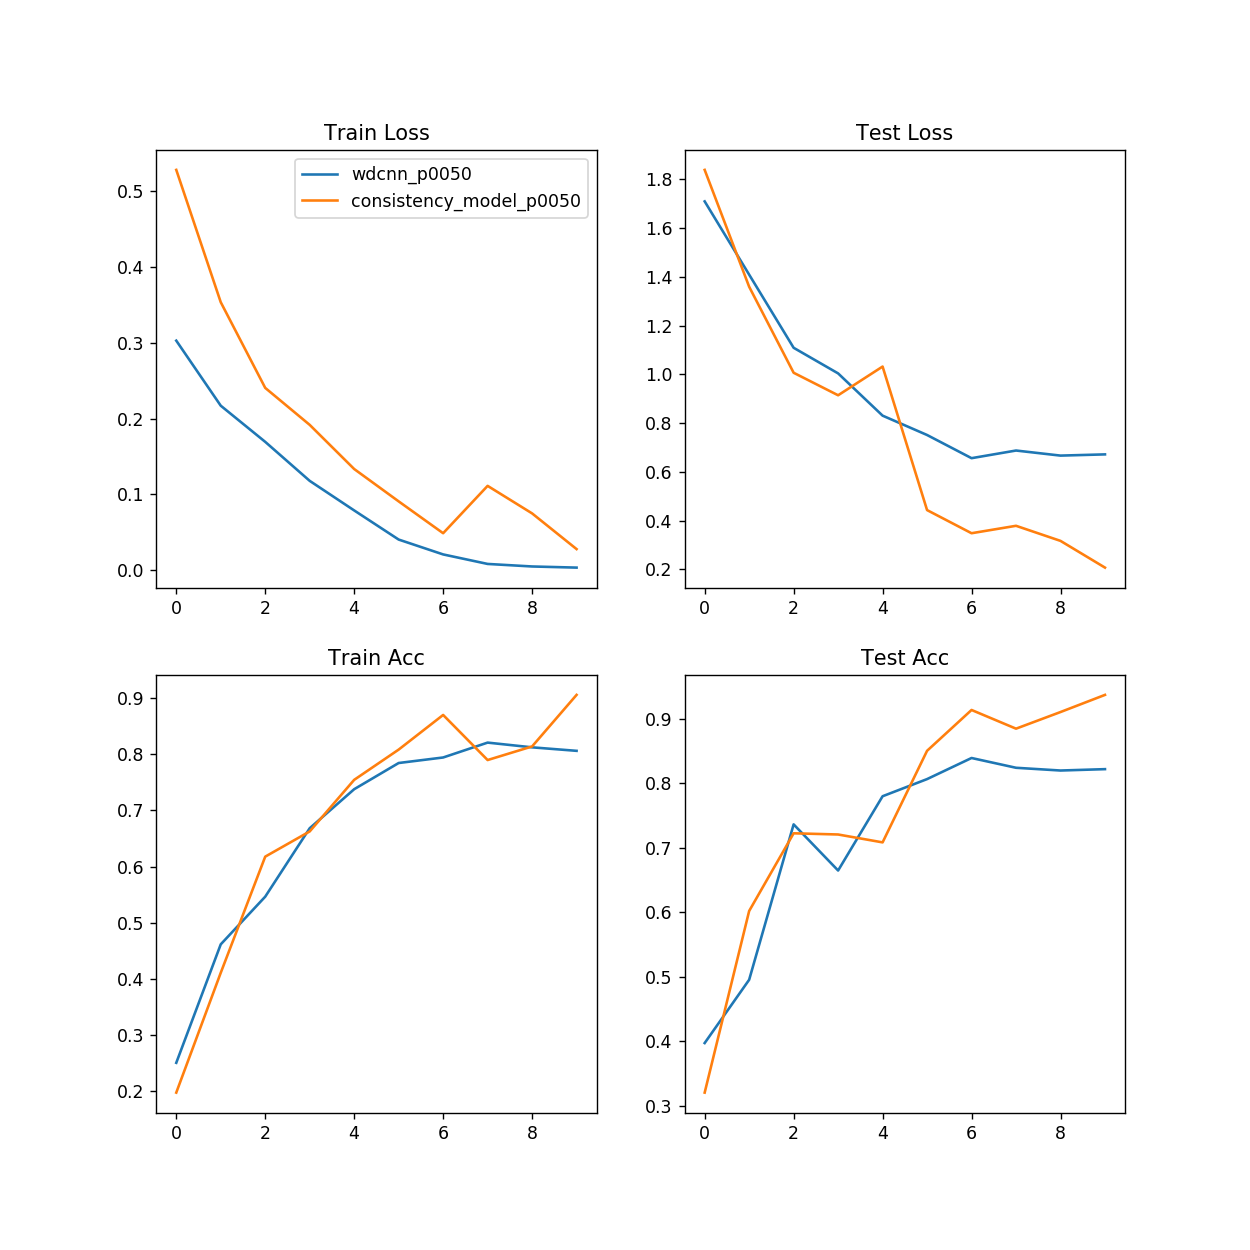

d:\users\jh\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # Remove the CWD from sys.path while we load stuff.


In [71]:
MODEL_NAMES = ['wdcnn_p0050', 'consistency_model_p0050']
plot_logs(MODEL_NAMES,LOG_PATH)

In [73]:
MODEL_NAME_EPOCHS = ['consistency_model_p0050_e10']
MODELS = [ConsistencyModel]
for i in range(len(MODEL_NAME_EPOCHS)):
    model = MODELS[i](model_name = MODEL_NAME_EPOCHS[i])
    model.load_state_dict(torch.load(SAVE_PATH+'/'+MODEL_NAME_EPOCHS[i]+'.pth'))
    
    test_model(model, overwrite=True)
    test_model(model, split='train', overwrite=True)

Model Name : consistency_model_p0050_e10
test dataset size:3760, labeled:3760, unlabeled:0
masks : [0:376, 1:376, 2:376, 3:376, 4:376, 5:376, 6:376, 7:376, 8:376, 9:376]
(test) consistency_model_p0050_e10 (SNR=None) :	0.936968085106383
test dataset size:3760, labeled:3760, unlabeled:0
masks : [0:376, 1:376, 2:376, 3:376, 4:376, 5:376, 6:376, 7:376, 8:376, 9:376]
(test) consistency_model_p0050_e10 (SNR=8) :	0.9148936170212766
test dataset size:3760, labeled:3760, unlabeled:0
masks : [0:376, 1:376, 2:376, 3:376, 4:376, 5:376, 6:376, 7:376, 8:376, 9:376]
(test) consistency_model_p0050_e10 (SNR=4) :	0.8625
test dataset size:3760, labeled:3760, unlabeled:0
masks : [0:376, 1:376, 2:376, 3:376, 4:376, 5:376, 6:376, 7:376, 8:376, 9:376]
(test) consistency_model_p0050_e10 (SNR=2) :	0.7970744680851064
test dataset size:3760, labeled:3760, unlabeled:0
masks : [0:376, 1:376, 2:376, 3:376, 4:376, 5:376, 6:376, 7:376, 8:376, 9:376]
(test) consistency_model_p0050_e10 (SNR=0) :	0.6917553191489362
trai

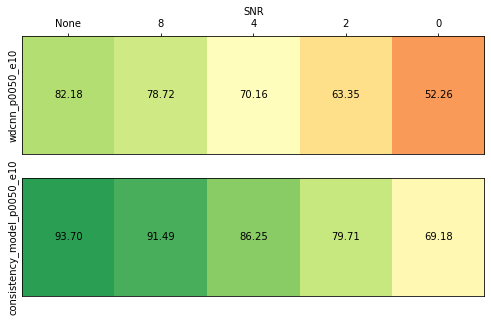

In [76]:
%matplotlib inline
MODEL_NAME_EPOCHS = ['wdcnn_p0050_e10', 'consistency_model_p0050_e10']
fig=plt.figure(figsize=(10,10))
make_table(MODEL_NAME_EPOCHS)

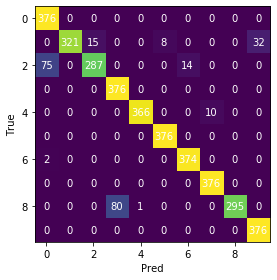

In [77]:
make_confmat(model_name = 'consistency_model_p0050_e10',snr=None)

train dataset size:14950, labeled:74, unlabeled:14876
masks : [0:8, 1:4, 2:8, 3:8, 4:6, 5:7, 6:8, 7:9, 8:9, 9:7]


C:\Users\jh\AppData\Roaming\Python\Python36\site-packages\matplotlib\collections.py:960: UserWarning: Collection without array used. Make sure to specify the values to be colormapped via the `c` argument.
  warnings.warn("Collection without array used. Make sure to "


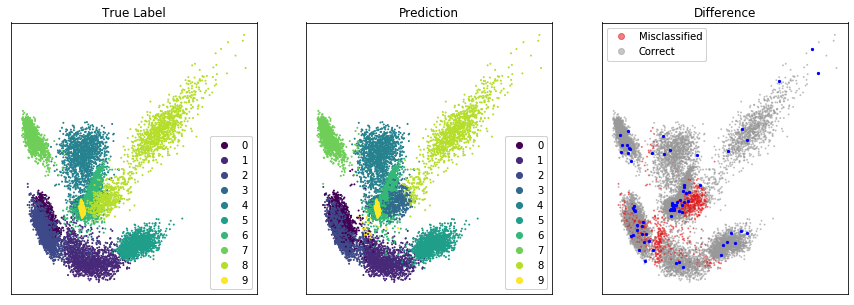

In [78]:
plot_latent('consistency_model_p0050_e10',split='train',p=0.005, mode='pca')

<IPython.core.display.Javascript object>


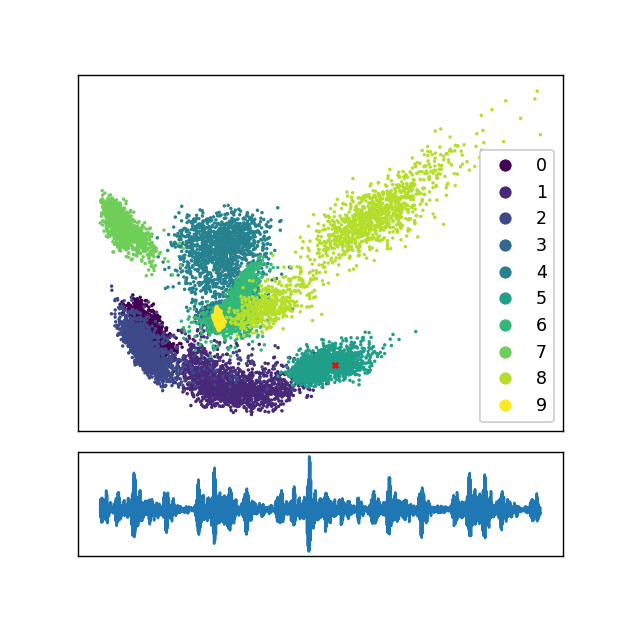

train dataset size:14950, labeled:74, unlabeled:14876
masks : [0:8, 1:4, 2:8, 3:8, 4:6, 5:7, 6:8, 7:9, 8:9, 9:7]


In [79]:
%matplotlib notebook
draw_magic('consistency_model_p0050_e10',split='train',p=0.005, legend=True, mode='pca')

***<Project.ipynb>에서 여러분만의 모델을 실험해보세요!***